## Import modules

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
from scipy import constants
from scipy.optimize import leastsq
from lmfit import minimize, Parameters, report_fit
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 5)

## Sort Data

In [3]:

data = pd.read_csv("../Data/GrowthRespPhotoData_new.csv", low_memory = False)


# get rid of 0s -ves and NAs from data (only +ves)
data2 = data.iloc[data.index[data["StandardisedTraitValue"] > 0]]

# get rid of ids with < 5 data points
data2 = data2.groupby("FinalID").filter(lambda x: len(x) > 5)

# set NewID based on OriginalID **do i even need to do this?**
data2["NewID"] = data2.FinalID.astype("category").cat.codes

# only columns i need
data2 = data2.loc[ : ,("NewID",
                       "FinalID",
                       "OriginalTraitName",
                       "OriginalTraitDef",
                       "OriginalTraitValue",
                       "OriginalTraitUnit",
                       "StandardisedTraitName",
                       "StandardisedTraitDef",
                       "StandardisedTraitValue",
                       "StandardisedTraitUnit",
                       "AmbientTemp",
                       "AmbientTempUnit",
                       "ConTemp",
                       "ConTempUnit",
                       "ResTemp",
                       "ResTempUnit",
                       "Consumer")]


## Explore data/plots

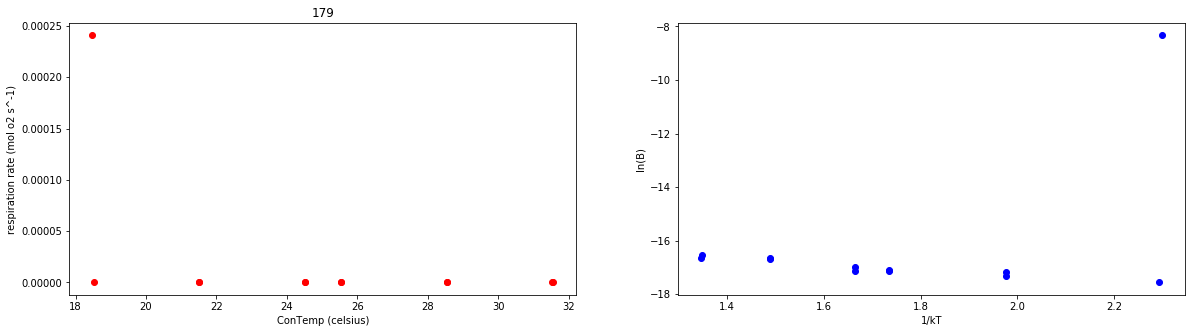

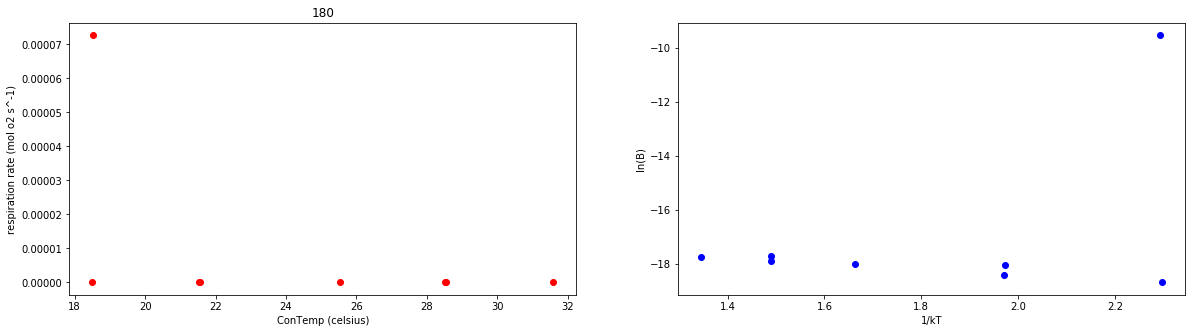

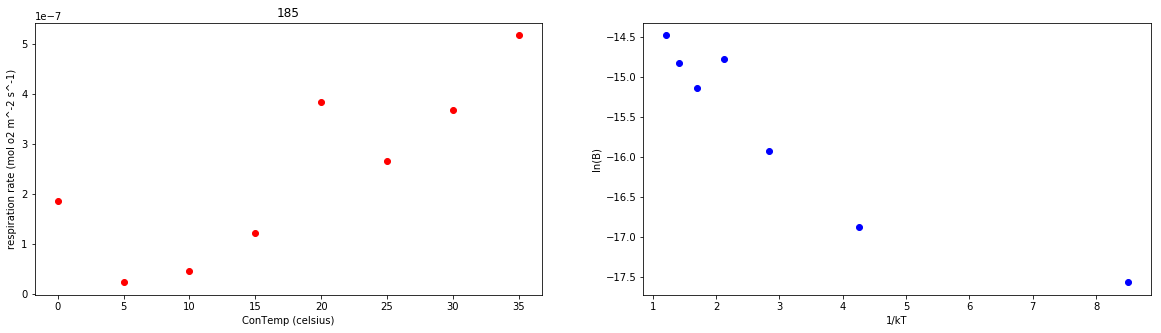

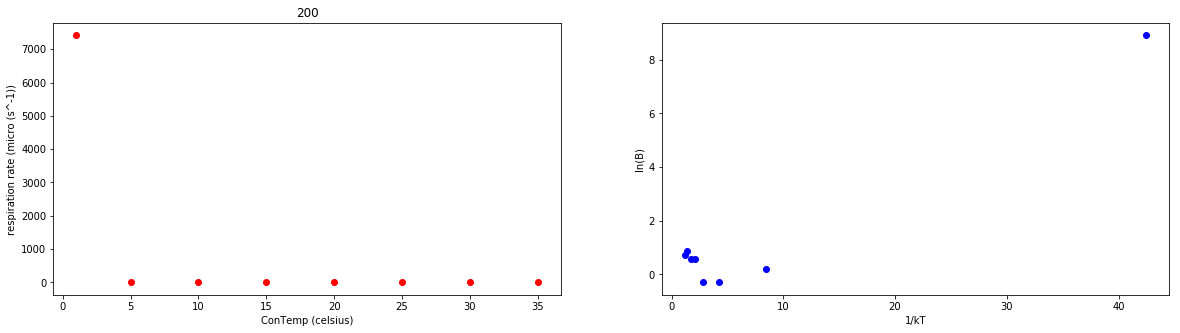

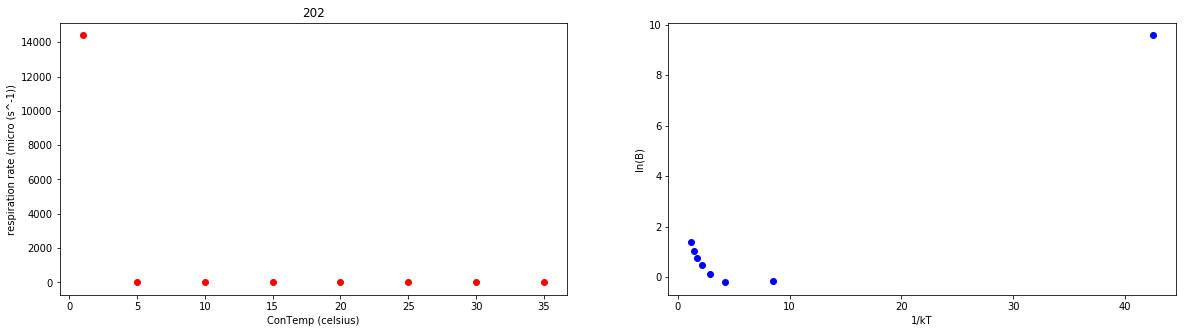

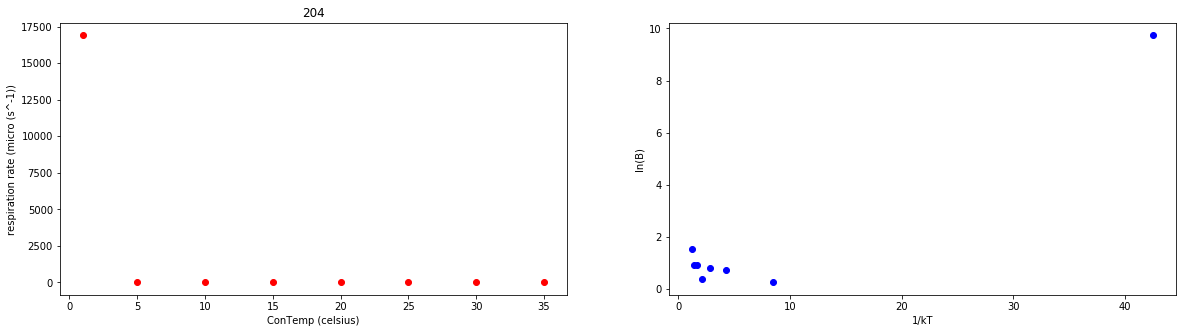

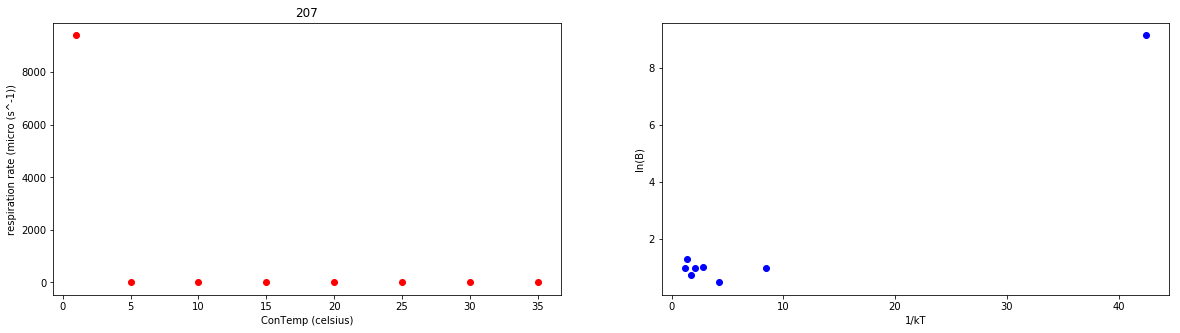

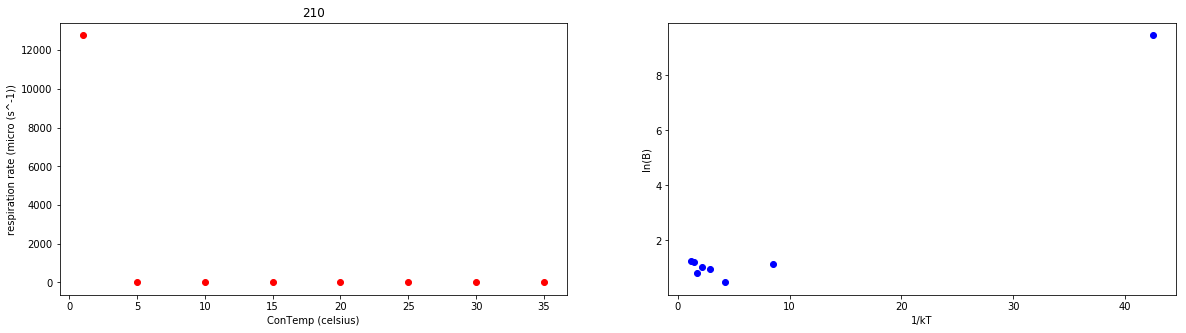

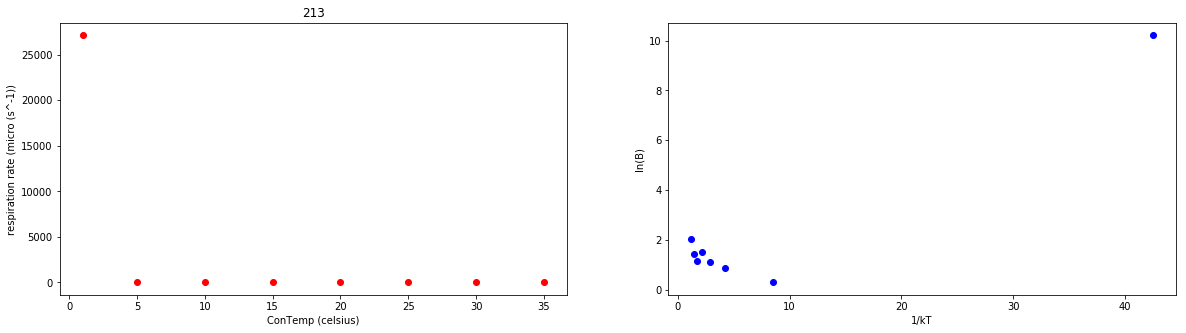

In [4]:
#pp = PdfPages('multipage.pdf')

for i in data2["NewID"].unique()[1:10]:

    tmp = data2[data2["NewID"] == i]
                
    if tmp.shape[0] > 5:
        y = tmp["StandardisedTraitValue"]
        ytitle = (tmp["StandardisedTraitName"].iloc[0] + " (" +
                  tmp["StandardisedTraitUnit"].iloc[0] + ")")

        if tmp["AmbientTemp"].isnull().any() == False:
            x = tmp["AmbientTemp"]
            xtitle = "AmbientTemp (" + tmp["AmbientTempUnit"].iloc[0] + ")"
        elif tmp["ConTemp"].isnull().any() == False:
            x = tmp["ConTemp"]
            xtitle = "ConTemp (" + tmp["ConTempUnit"].iloc[0] + ")"
        elif tmp["ResTemp"].isnull().any() == False:
            x = tmp["ResTemp"]
            xtitle = "ResTemp (" + tmp["ResTempUnit"].iloc[0] + ")"

        plt.subplot(1, 2, 1)
        plt.plot(x, y, 'ro')
        plt.xlabel(xtitle)
        plt.ylabel(ytitle)
        plt.title(i)
        
        plt.subplot(1, 2, 2)
        plt.plot((1/((x*273.15)*constants.value('Boltzmann constant in eV/K'))),
                 (np.log(y)), 'bo')
        plt.xlabel("1/kT")
        plt.ylabel("ln(B)")
        
        plt.show()
        #pp.savefig()
        
#pp.close()

## Choose a curve to inspect

In [5]:
test = data2[data2["NewID"] == 952]
test = test.sort_values("ConTemp")
x = test.ConTemp
data = test.StandardisedTraitValue

## General cubic polynomial model

$$ \large B = B_0 + B_1T + B_2T^2 + B_3T^3 $$

[[Fit Statistics]]
    # function evals   = 12
    # data points      = 58
    # variables        = 4
    chi-square         = 0.000
    reduced chi-square = 0.000
    Akaike info crit   = -1514.628
    Bayesian info crit = -1506.387
[[Variables]]
    a:   1.5166e-05 +/- 2.33e-06 (15.35%) (init= 0)
    b:  -2.0740e-06 +/- 2.53e-07 (12.22%) (init= 0)
    c:   8.3168e-08 +/- 7.90e-09 (9.50%) (init= 0)
    d:  -8.2596e-10 +/- 7.35e-11 (8.89%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(c, d)                      = -0.991 
    C(b, c)                      = -0.983 
    C(a, b)                      = -0.960 
    C(b, d)                      =  0.951 
    C(a, c)                      =  0.902 
    C(a, d)                      = -0.848 


<IPython.core.display.Javascript object>


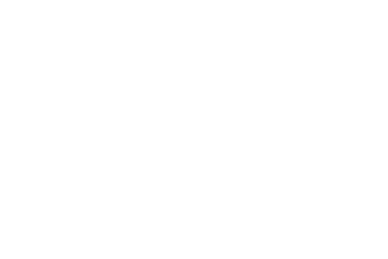

<IPython.core.display.Javascript object>


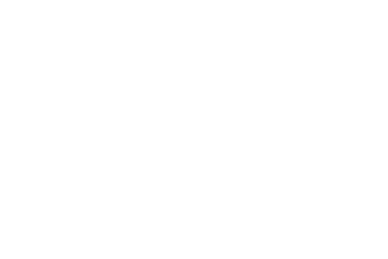

In [6]:
params = Parameters()
params.add('a', value = 0.)
params.add('b', value = 0.)
params.add('c', value = 0.)
params.add('d', value = 0.)

def get_residual(params, x, data):
    a = params['a'].value 
    b = params['b'].value
    c = params['c'].value 
    d = params['d'].value 
    
    model = a + b*x + c*x**2 + d*x**3
    
    return model - data

out1 = minimize(get_residual, params, args = (x, data))

report_fit(out1)

%matplotlib notebook
plt.plot(x, data, 'bo')
plt.plot(x, get_residual(out1.params, x, data) + data, 'r')
plt.show()

## Schoolfield Model

$$ \large B = \frac{B_0e^{\frac{-E}{k}(\frac{1}{T} - \frac{1}{283.15})}}{1 + e^{\frac{-E_l}{k}(\frac{1}{T_l}-\frac{1}{T})} + e^{\frac{-E_h}{k}(\frac{1}{T_h}-\frac{1}{T})}} $$

[[Fit Statistics]]
    # function evals   = 595
    # data points      = 58
    # variables        = 6
    chi-square         = 0.000
    reduced chi-square = 0.000
    Akaike info crit   = -1589.876
    Bayesian info crit = -1577.513
[[Variables]]
    B0:   8.47089441 +/- 0        (0.00%) (init= 1e-05)
    E:   -2.14208690 +/- 0        (0.00%) (init= 1e-05)
    El:   1.0000e-05 +/- 0        (0.00%) (init= 1e-05)
    Eh:  -2.75220731 +/- 0        (0.00%) (init= 1e-05)
    Tl:   290        +/- 0        (0.00%) (init= 290)
    Th:   329.977141 +/- 0        (0.00%) (init= 290)
    e:    2.718282 (fixed)
    k:    8.61733e-05 (fixed)


<IPython.core.display.Javascript object>


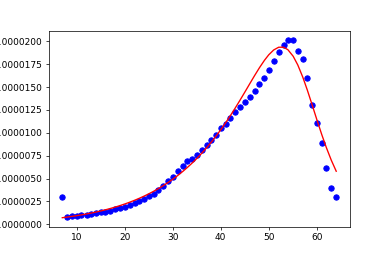

In [7]:
sparams = Parameters()
sparams.add('B0', value = 0.00001)
sparams.add('E',  value = 0.00001)
sparams.add('El', value = 0.00001)
sparams.add('Eh', value = 0.00001)
sparams.add('Tl', value = 290, min = 260, max = 330)
sparams.add('Th', value = 290, min = 260, max = 330)
sparams.add('e',  value = np.exp(1), vary = False)
sparams.add('k',  value = constants.value('Boltzmann constant in eV/K'), vary = False)

def schlfld_residual(sparams, x, data):
    B0 = sparams['B0'].value 
    E  = sparams['E'].value 
    El = sparams['El'].value 
    Eh = sparams['Eh'].value
    Tl = sparams['Tl'].value
    Th = sparams['Th'].value
    
    e = sparams['e'].value
    k = sparams['k'].value
    
    model = (B0*e**((-E/k)*((1/(x+ 273.15))-(1/283.15))))/(1+e**((El/k)*((1/Tl)-(1/x+273.15)))+(e**((Eh/k)*((1/Th)-(1/(x+ 273.15))))))
        
    return model - data


out2 = minimize(schlfld_residual, sparams, args = (x, data))

report_fit(out2)
%matplotlib notebook
plt.plot(x, data, 'bo')
plt.plot(x, schlfld_residual(out2.params, x, data) + data, 'r')

## Enzyme-assisted Arrhenius model

$$ \large V = A_0e\frac{-(E_b-(E_{\Delta H}(1 - \frac{T}{T_m}) + E_{\Delta Cp}(T - T_m - T\ln\frac{T}{T_m})))}{kT} $$

[[Fit Statistics]]
    # function evals   = 87
    # data points      = 58
    # variables        = 5
    chi-square         = 0.000
    reduced chi-square = 0.000
    Akaike info crit   = -1443.916
    Bayesian info crit = -1433.613
[[Variables]]
    A0:   1.0000e-05 +/- 0        (0.00%) (init= 1e-05)
    Eb:  -3.2657e-12 +/- 0        (0.00%) (init= 1e-05)
    Ec:   1.0501e-12 +/- 0        (0.00%) (init= 1e-05)
    Eh:  -1.2234e-11 +/- 0        (0.00%) (init= 1e-05)
    Tm:   319.481585 +/- 0        (0.00%) (init= 290)
    e:    2.718282 (fixed)
    k:    8.61733e-05 (fixed)


<IPython.core.display.Javascript object>


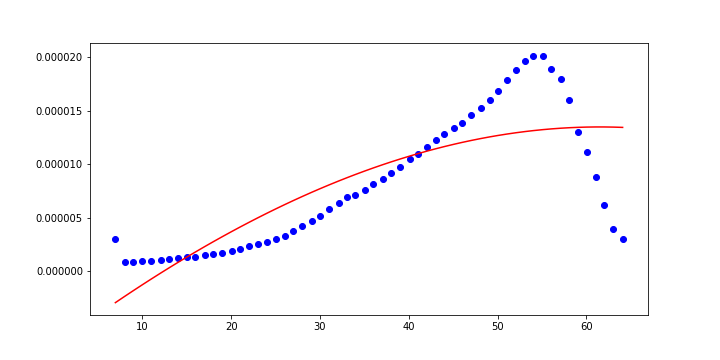

In [46]:
aparams = Parameters()
aparams.add('A0', value = 0.00001)
aparams.add('Eb', value = 0.00001)
aparams.add('Ec', value = 0.00001)
aparams.add('Eh', value = 0.00001)
aparams.add('Tm', value = 290, min = 260, max = 330)
aparams.add('e', value = np.exp(1), vary = False)
aparams.add('k', value = constants.value('Boltzmann constant in eV/K'), vary = False)

def arrhenius_residual(aparams, xVals, yVals):
    A0 = aparams['A0'].value 
    Eb = aparams['Eb'].value
    Ec = aparams['Ec'].value
    Eh = aparams['Eh'].value
    Tm = aparams['Tm'].value
    e  = aparams['e'].value
    k  = aparams['k'].value
    
    model = -(Eb-(Eh*(1-((x+273.15)/Tm))+Ec*((x+273.15)-Tm-(x+273.15)*np.log((x+273.15)/Tm))))/k*(x+273.15)
    
    return model - data


out3 = minimize(arrhenius_residual, aparams, args = (x, data))

report_fit(out3)
%matplotlib notebook
plt.plot(x, data, 'bo')
plt.plot(x, arrhenius_residual(out3.params, x, data) + data, 'r')

In [8]:
x

7733     6.97401
7734     8.00820
7735     8.96843
7736    10.00250
7737    10.96270
7738    12.07080
7739    13.03120
7740    13.99160
7741    15.02560
7742    15.91210
7743    17.02030
7744    17.98070
7745    19.01500
7746    20.04940
7747    21.01010
7748    22.04460
7749    23.00510
7750    24.03980
7751    25.00070
7752    26.03540
7753    26.99660
7754    28.03180
7755    29.06690
7756    29.95450
7757    30.99000
7758    32.09940
7759    33.06090
7760    33.94780
7761    35.05670
7762    36.01830
7763    37.05350
7764    38.01510
7765    39.05060
7766    40.08640
7767    41.04780
7768    42.00960
7769    43.04530
7770    44.00680
7771    45.11600
7772    46.00360
7773    47.03940
7774    48.07520
7775    49.11100
7776    49.99960
7777    51.03620
7778    52.07240
7779    53.10860
7780    53.99610
7781    55.10410
7782    56.06100
7783    57.09260
7784    58.04750
7785    59.07380
7786    60.02890
7787    61.05700
7788    62.01020
7789    63.03850
7790    64.06990
Name: ConTemp,